# Getting Data Ready for Modeling

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Load the NBA merged data
nba_data = pd.read_csv('nba_merged_data.csv')

# Drop unnecessary columns
nba_data = nba_data.loc[:, ~nba_data.columns.str.contains('_RANK$')]

# sorted by game date
nba_data = nba_data.sort_values(by='GAME_DATE').reset_index(drop=True)

print(nba_data['PLAYOFF_WINS'].head())

def categorize_playoff_type(wins):
    if wins == 0:
        return 0
    elif 1 <= wins <= 3:
        return 1
    elif 4 <= wins <= 7:
        return 2
    elif 8 <= wins <= 11:
        return 3
    elif 12 <= wins <= 15:
        return 4
    elif wins == 16:
        return 5

nba_data['PLAYOFF_WINS'] = nba_data['PLAYOFF_WINS'].apply(categorize_playoff_type).apply(pd.Series).astype('category')

print(nba_data['PLAYOFF_WINS'].head())


0    0
1    3
2    9
3    1
4    0
Name: PLAYOFF_WINS, dtype: int64
0    0
1    1
2    3
3    1
4    0
Name: PLAYOFF_WINS, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]


In [3]:
# Unnecessary columns for model
columns_to_exclude = [
    'SEASON_YEAR', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME',
    'GAME_ID', 'GAME_DATE', 'MATCHUP', 'MIN',
    'AVAILABLE_FLAG', 'PLAYOFF_WINS'
]

# change data type of WL to binary 
nba_data['WL'] = nba_data['WL'].map({'W': 1, 'L': 0})
nba_data['WL'] = nba_data['WL'].astype('category')



In [ ]:
# split data into x and y
def XYSplit(df):
    scaler = StandardScaler()
    x = df.drop(columns=columns_to_exclude)
    y = df['PLAYOFF_WINS']
    x = scaler.fit_transform(x)
    return {"x": x, "y": y}

# get ful data xy
def FullDataXYSplit(df):
    NeuralNetData = {}

    # Store training data season by season
    for season in df['SEASON_YEAR'].unique():
        season_df = df[df['SEASON_YEAR'] == season]
        NeuralNetData[season] = XYSplit(season_df)

    return NeuralNetData

# used to print the structure of the dictionary
def print_dict_structure(d, indent=0):
    for key, value in d.items():
        print('  ' * indent + f"{key}: {type(value).__name__}")
        if isinstance(value, dict):
            print_dict_structure(value, indent + 1)

# get the data
def getXYTrainTest(lib, trainSeason, testSeason):
    return lib[trainSeason]['x'], lib[trainSeason]['y'].values, lib[testSeason]['x'], lib[testSeason]['y'].values


In [5]:
model_data = FullDataXYSplit(nba_data)

print_dict_structure(model_data)

def combineYears(model_data, years):
    
    # Initialize empty lists to hold the data
    combined_x = []
    combined_y = []
    
    # Loop through the specified years and aggregate the data
    for year in years:
        if year in model_data:
            combined_x.append(model_data[year]['x'])
            combined_y.append(model_data[year]['y'])
        else:
            print(f"Warning: Year {year} not found in the model_data.")

    # Concatenate all the x and y data (assuming x is ndarray and y is Series)
    combined_x = np.concatenate(combined_x, axis=0)  # Concatenate along the first axis (rows)
    combined_y = pd.concat(combined_y, axis=0)       # Concatenate along the first axis (rows)
    
    # Create a new dictionary entry with the combined data
    combined_data = {
        'x': combined_x,
        'y': combined_y
    }
    
    return combined_data

combinedData = combineYears(model_data, ['2014-15','2015-16','2016-17','2017-18','2018-19','2019-20','2020-21', '2021-22', '2022-23'])

model_data['2014-23'] = combinedData

print_dict_structure(model_data)

2014-15: dict
  x: ndarray
  y: Series
2015-16: dict
  x: ndarray
  y: Series
2016-17: dict
  x: ndarray
  y: Series
2017-18: dict
  x: ndarray
  y: Series
2018-19: dict
  x: ndarray
  y: Series
2019-20: dict
  x: ndarray
  y: Series
2020-21: dict
  x: ndarray
  y: Series
2021-22: dict
  x: ndarray
  y: Series
2022-23: dict
  x: ndarray
  y: Series
2023-24: dict
  x: ndarray
  y: Series
2014-15: dict
  x: ndarray
  y: Series
2015-16: dict
  x: ndarray
  y: Series
2016-17: dict
  x: ndarray
  y: Series
2017-18: dict
  x: ndarray
  y: Series
2018-19: dict
  x: ndarray
  y: Series
2019-20: dict
  x: ndarray
  y: Series
2020-21: dict
  x: ndarray
  y: Series
2021-22: dict
  x: ndarray
  y: Series
2022-23: dict
  x: ndarray
  y: Series
2023-24: dict
  x: ndarray
  y: Series
2014-23: dict
  x: ndarray
  y: Series


# Modeling

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

# Train season n, predict n+1

In [31]:
def combineYears(model_data, years):
    
    # Initialize empty lists to hold the data
    combined_x = []
    combined_y = []
    
    # Loop through the specified years and aggregate the data
    for year in years:
        if year in model_data:
            combined_x.append(model_data[year]['x'])
            combined_y.append(model_data[year]['y'])
        else:
            print(f"Warning: Year {year} not found in the model_data.")

    # Concatenate all the x and y data (assuming x is ndarray and y is Series)
    combined_x = np.concatenate(combined_x, axis=0)  # Concatenate along the first axis (rows)
    combined_y = pd.concat(combined_y, axis=0)       # Concatenate along the first axis (rows)
    
    # Create a new dictionary entry with the combined data
    combined_data = {
        'x': combined_x,
        'y': combined_y
    }
    
    return combined_data

# Modify the model for multi-class classification
def getModel(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer with Softmax activation
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Use categorical cross-entropy
    return model


def graphModel(trainPef, testPerf, trainSeason, testSeason, monthIndices):
    # Create a figure and axis to return for editing
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(range(len(trainPef)), trainPef, label="Unused Train Accuracy", color='blue')
    ax.plot(range(len(testPerf)), testPerf, label="Test Accuracy", color='red')

    # Add vertical lines and labels for each month change
    for idx, month in monthIndices:
        ax.axvline(x=idx, color='gray', linestyle='--', linewidth=1)
        ax.text(
            idx + 1,  # small offset to the right
            ax.get_ylim()[0],  # place at the bottom of the plot
            month,
            rotation=90,
            verticalalignment='bottom',
            horizontalalignment='left',
            fontsize=8,
            color='black'
        )

    title = f"{trainSeason} to predict {testSeason}"
    ax.set_title(title)
    ax.set_xlabel('Batch')
    ax.set_ylabel('Accuracy')
    ax.legend()

    

def get_month_change_batches(nba_df, season_year, batch_size):
    month_names = {
        1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June",
        7: "July", 8: "August", 9: "September", 10: "October", 11: "November", 12: "December"
    }

    # Filter and reset index (without modifying original)
    games = nba_df[nba_df['SEASON_YEAR'] == season_year].reset_index(drop=True)

    # Convert GAME_DATE to datetime
    game_dates = pd.to_datetime(games['GAME_DATE'])
    months = game_dates.dt.month

    # Detect changes in month
    month_change_batches = []
    prev_month = None

    for idx, month in enumerate(months):
        if month != prev_month:
            batch_index = idx // batch_size
            month_change_batches.append((batch_index, month_names[month]))
            prev_month = month

    return month_change_batches

def get_season_change_batches(nba_df, batch_size):
    # Reset index without modifying original DataFrame
    data = nba_df.reset_index(drop=True)

    # Get season year values
    seasons = data['SEASON_YEAR']

    # Detect changes in season
    season_change_batches = []
    prev_season = None

    for idx, season in enumerate(seasons):
        if season != prev_season:
            batch_index = idx // batch_size
            season_change_batches.append((batch_index, season))
            prev_season = season

    return season_change_batches


def runModel(model_data, training_season, testing_season, batch_size):
    x_train_all, y_train_all, x_test, y_test = getXYTrainTest(model_data, training_season, testing_season)

        # Ensure the input shape of the model is correct
    model = getModel(x_train_all.shape[1], 6)
    
    train_mae_list = []
    test_mae_list = []
    y_test = pd.get_dummies(y_test)

    for i in range(0, len(x_train_all), batch_size):
        
        if i + batch_size >= len(x_train_all):
            break  # Don't try to train on an incomplete final batch

        print("batch:", ((i+batch_size)/batch_size), ",", "trained index:", i+batch_size)

        # train on batch size of sample units
        x_train = x_train_all[i:i + batch_size]
        y_train = pd.get_dummies(y_train_all[i:i + batch_size])

        model.fit(x_train, y_train, epochs=1, shuffle=False, verbose=1)

        # Evaluate on training data used so far
        train_mae = model.evaluate(x_train_all[i + batch_size:], pd.get_dummies(y_train_all[i + batch_size:]), verbose=0)
        test_mae = model.evaluate(x_test, y_test, verbose=0)

        train_mae_list.append(train_mae[1])
        test_mae_list.append(test_mae[1])

    return train_mae_list, test_mae_list




In [18]:
train_mse_list, test_mae_list = runModel(model_data, '2022-23', '2023-24', 10)

batch: 1.0 , trained index: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.1000 - loss: 1.9105
batch: 2.0 , trained index: 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2000 - loss: 1.6184
batch: 3.0 , trained index: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4000 - loss: 1.7197
batch: 4.0 , trained index: 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4000 - loss: 1.5583
batch: 5.0 , trained index: 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5000 - loss: 1.5364
batch: 6.0 , trained index: 60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5000 - loss: 1.4093
batch: 7.0 , trained index: 70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4000 - loss: 1.6799
batch: 8.0 , trained index: 80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7000 - loss: 1.3903
batch: 9.0 , trained index: 90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3000 - loss: 1.7974
batch: 10.0 , trained index: 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step -

[(0, 'October'), (20, 'November'), (64, 'December'), (109, 'January'), (153, 'February'), (186, 'March'), (232, 'April')]


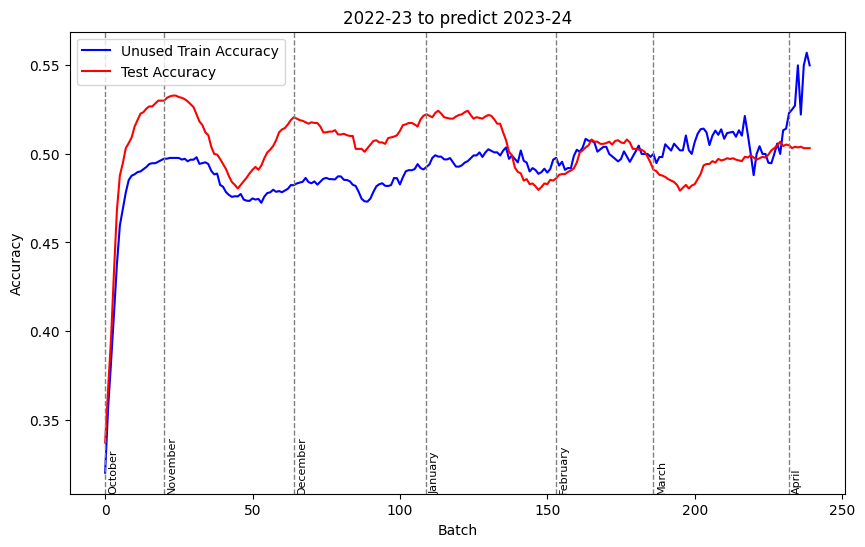

In [28]:
monthChanges = get_month_change_batches(nba_data, '2022-23', 10)
print(monthChanges)

graphModel(train_mse_list[:240], test_mae_list[:240], '2022-23', '2023-24', monthChanges)



In [29]:
train_mse_list, test_mae_list = runModel(model_data, '2014-23', '2023-24', 100)


batch: 1.0 , trained index: 100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1378 - loss: 1.8644  
batch: 2.0 , trained index: 200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4076 - loss: 1.5791 
batch: 3.0 , trained index: 300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5750 - loss: 1.3071 
batch: 4.0 , trained index: 400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5884 - loss: 1.2807
batch: 5.0 , trained index: 500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5646 - loss: 1.2465
batch: 6.0 , trained index: 600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5705 - loss: 1.2433
batch: 7.0 , trained index: 700
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5811 - loss: 1.2462 
batch: 8.0 , trained index: 800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5679 - loss: 1.3114
batch: 9.0 , trained index: 900
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5698 - loss: 1.2883
batch: 10.0 , trained index: 1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

[(0, '2014-15'), (24, '2015-16'), (49, '2016-17'), (73, '2017-18'), (98, '2018-19'), (123, '2019-20'), (144, '2020-21'), (165, '2021-22'), (190, '2022-23'), (214, '2023-24')]


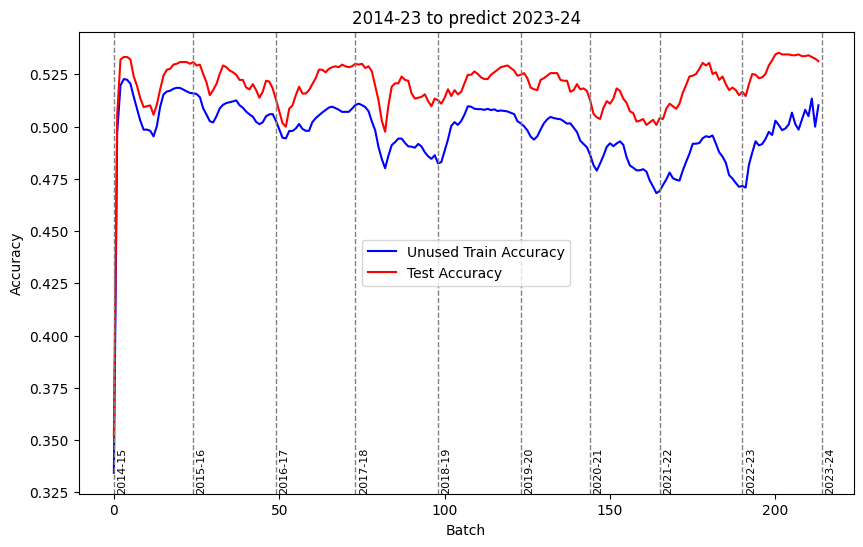

In [32]:
seasonChanges = get_season_change_batches(nba_data, 100)
print(seasonChanges)
graphModel(train_mse_list, test_mae_list, '2014-23', '2023-24', seasonChanges)

In [56]:
def runModelCont(model, model_data, training_season, testing_season, batch_size):

    x_train_all, y_train_all, x_test, y_test = getXYTrainTest(model_data, training_season, testing_season)
    
    test_mae_list = []
    y_test = pd.get_dummies(y_test)

    for i in range(0, len(x_train_all), batch_size):
        
        if i + batch_size >= len(x_train_all):
            break  # Don't try to train on an incomplete final batch

        print("batch:", ((i+batch_size)/batch_size), ",", "trained index:", i+batch_size)

        # train on batch size of sample units
        x_train = x_train_all[i:i + batch_size]
        y_train = pd.get_dummies(y_train_all[i:i + batch_size])

        model.fit(x_train, y_train, epochs=1, shuffle=False, verbose=1)

        test_mae = model.evaluate(x_test, y_test, verbose=0)

        test_mae_list.append(test_mae[1])

    return test_mae_list


def run_full_continual_training(model, model_data, batch_size):
    test_mae_dict = {}

    season_keys = list(model_data.keys())

    for i in range(len(season_keys) - 2):
        training_season = season_keys[i]
        testing_season = season_keys[i + 1]

        print(f"\nTraining on {training_season}, testing on {testing_season}")
        test_mae = runModelCont(model, model_data, training_season, testing_season, batch_size)

        test_mae_dict[training_season] = test_mae

    return test_mae_dict


# Example usage:
input_dim = model_data['2014-15']['x'].shape[1]  # Get input shape from first season
num_classes = 6  # You defined 6 playoff categories earlier
model = getModel(input_dim, num_classes)

# Run continual training
test_mae_results = run_full_continual_training(model, model_data, batch_size=100)







Training on 2014-15, testing on 2015-16
batch: 1.0 , trained index: 100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2822 - loss: 1.7110  
batch: 2.0 , trained index: 200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5059 - loss: 1.4882 
batch: 3.0 , trained index: 300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6058 - loss: 1.2919 
batch: 4.0 , trained index: 400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5884 - loss: 1.2157 
batch: 5.0 , trained index: 500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5646 - loss: 1.1952 
batch: 6.0 , trained index: 600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5705 - loss: 1.2140 
batch: 7.0 , trained index: 700
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5750 - loss: 1.2390
batch: 8.0 , trained index: 800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5504 - loss: 1.3056 
batch: 9.0 , trained index: 900
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5082 - loss: 1.2965 
batch: 10.0 , trained i

In [57]:
# Print the first key-value pair in the dictionary
first_key = list(test_mae_results.keys())[0]
first_value = test_mae_results[first_key]

print(f"First key: {first_key}")
print(f"First value: {first_value}")


First key: 2014-15
First value: [0.4670731723308563, 0.5268292427062988, 0.5341463685035706, 0.5345528721809387, 0.5357723832130432, 0.5333333611488342, 0.5313008427619934, 0.5288617610931396, 0.5256097316741943, 0.5288617610931396, 0.5292682647705078, 0.5300812721252441, 0.5280487537384033, 0.5276422500610352, 0.5329268574714661, 0.5325203537940979, 0.5349593758583069, 0.5349593758583069, 0.5349593758583069, 0.5329268574714661, 0.5337398648262024, 0.5304877758026123, 0.5304877758026123, 0.529674768447876]


In [58]:
all_results = []
for season, results in test_mae_results.items():
    all_results.extend(results)

all_results = np.array(all_results)
print(all_results)

[0.46707317 0.52682924 0.53414637 0.53455287 0.53577238 0.53333336
 0.53130084 0.52886176 0.52560973 0.52886176 0.52926826 0.53008127
 0.52804875 0.52764225 0.53292686 0.53252035 0.53495938 0.53495938
 0.53495938 0.53292686 0.53373986 0.53048778 0.53048778 0.52967477
 0.52723575 0.52682924 0.52601624 0.51910567 0.51707315 0.51504064
 0.51829267 0.51951218 0.51991868 0.51910567 0.51585364 0.51178861
 0.50853658 0.5004065  0.49430895 0.48292682 0.4817073  0.48211381
 0.48373982 0.48455286 0.4813008  0.48048779 0.4813008  0.48048779
 0.46260163 0.45813009 0.46056911 0.46747968 0.47113821 0.47113821
 0.47398373 0.47845528 0.48008129 0.4808943  0.47520325 0.47804877
 0.48373982 0.48617887 0.4890244  0.49471545 0.5        0.5004065
 0.50081301 0.49918699 0.49796748 0.49837399 0.49878049 0.50081301
 0.51951218 0.51178861 0.50162601 0.49186993 0.48780489 0.49268293
 0.49227643 0.49349594 0.49105692 0.47967479 0.47845528 0.48658538
 0.49430895 0.49227643 0.49227643 0.49796748 0.50569105 0.50731

In [62]:
key_size_list = []
previous_size = -24

for key, value in test_mae_results.items():
    current_size = len(value) + previous_size
    key_size_list.append((key, current_size))
    previous_size = current_size



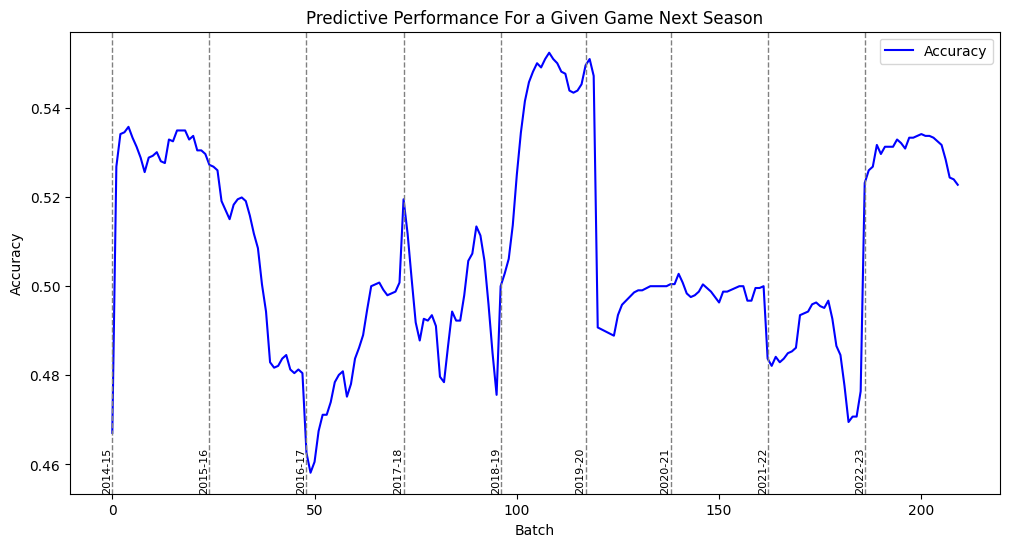

In [63]:
import matplotlib.pyplot as plt

# Plot all_results
plt.figure(figsize=(12, 6))
plt.plot(all_results, label='Accuracy', color='blue')

# Add dashed vertical lines for each key_size_list entry
for key, size in key_size_list:
    plt.axvline(x=size, color='gray', linestyle='--', linewidth=1)
    plt.text(size, plt.ylim()[0], key, rotation=90, verticalalignment='bottom', horizontalalignment='right', fontsize=8, color='black')

# Add labels and legend
plt.title('Predictive Performance For a Given Game Next Season')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)
plt.show()